# NYC Restaurant Inspection Results

In [53]:
import pandas as pd
from sodapy import Socrata
from config import API_Key, username, password
import requests
import json
import matplotlib.pyplot as plt
import re, datetime

from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.io import show, output_notebook
from bokeh.transform import dodge
from bokeh.core.properties import value

## 1. Loading Data from API

In [2]:
# Example authenticated client (needed for non-public datasets):
client = Socrata("data.cityofnewyork.us", API_Key, username, password)

# Returned as JSON from API by sodapy.
data = client.get("43nn-pn8j",limit=381912)

# Convert to pandas DataFrame
data_df = pd.DataFrame.from_records(data)

In [28]:
data_df.head(20)

,action,boro,building,camis,critical_flag,cuisine_description,dba,grade,grade_date,inspection_date,inspection_type,phone,record_date,score,street,violation_code,violation_description,zipcode
0,Violations were cited in the following area(s).,BRONX,1007,30075445,Not Critical,Bakery,MORRIS PARK BAKE SHOP,A,2018-05-11T00:00:00.000,2018-05-11T00:00:00.000,Cycle Inspection / Initial Inspection,7188924968,2019-05-01T06:00:34.000,5,MORRIS PARK AVE,08C,Pesticide use not in accordance with label or ...,10462
1,Violations were cited in the following area(s).,BRONX,1007,30075445,Not Critical,Bakery,MORRIS PARK BAKE SHOP,A,2018-05-11T00:00:00.000,2018-05-11T00:00:00.000,Cycle Inspection / Initial Inspection,7188924968,2019-05-01T06:00:34.000,5,MORRIS PARK AVE,10F,Non-food contact surface improperly constructe...,10462
2,Violations were cited in the following area(s).,BRONX,1007,30075445,Critical,Bakery,MORRIS PARK BAKE SHOP,A,2017-05-18T00:00:00.000,2017-05-18T00:00:00.000,Cycle Inspection / Initial Inspection,7188924968,2019-05-01T06:00:34.000,7,MORRIS PARK AVE,06D,"Food contact surface not properly washed, rins...",10462
3,Violations were cited in the following area(s).,BRONX,1007,30075445,Not Critical,Bakery,MORRIS PARK BAKE SHOP,A,2017-05-18T00:00:00.000,2017-05-18T00:00:00.000,Cycle Inspection / Initial Inspection,7188924968,2019-05-01T06:00:34.000,7,MORRIS PARK AVE,10F,Non-food contact surface improperly constructe...,10462
4,Violations were cited in the following area(s).,BRONX,1007,30075445,Critical,Bakery,MORRIS PARK BAKE SHOP,A,2016-02-18T00:00:00.000,2016-02-18T00:00:00.000,Cycle Inspection / Initial Inspection,7188924968,2019-05-01T06:00:34.000,10,MORRIS PARK AVE,04L,Evidence of mice or live mice present in facil...,10462
5,Violations were cited in the following area(s).,BRONX,1007,30075445,Not Critical,Bakery,MORRIS PARK BAKE SHOP,A,2016-02-18T00:00:00.000,2016-02-18T00:00:00.000,Cycle Inspection / Initial Inspection,7188924968,2019-05-01T06:00:34.000,10,MORRIS PARK AVE,08A,Facility not vermin proof. Harborage or condit...,10462
6,Violations were cited in the following area(s).,BROOKLYN,469,30112340,Critical,Hamburgers,WENDY'S,A,2019-03-04T00:00:00.000,2019-03-04T00:00:00.000,Cycle Inspection / Initial Inspection,7182875005,2019-05-01T06:00:34.000,13,FLATBUSH AVENUE,02G,Cold food item held above 41Âº F (smoked fish ...,11225
7,Violations were cited in the following area(s).,BROOKLYN,469,30112340,Not Critical,Hamburgers,WENDY'S,A,2019-03-04T00:00:00.000,2019-03-04T00:00:00.000,Cycle Inspection / Initial Inspection,7182875005,2019-05-01T06:00:34.000,13,FLATBUSH AVENUE,10B,Plumbing not properly installed or maintained;...,11225
8,Violations were cited in the following area(s).,BROOKLYN,469,30112340,Not Critical,Hamburgers,WENDY'S,A,2019-03-04T00:00:00.000,2019-03-04T00:00:00.000,Cycle Inspection / Initial Inspection,7182875005,2019-05-01T06:00:34.000,13,FLATBUSH AVENUE,10F,Non-food contact surface improperly constructe...,11225
9,Violations were cited in the following area(s).,BROOKLYN,469,30112340,Critical,Hamburgers,WENDY'S,A,2018-03-13T00:00:00.000,2018-03-13T00:00:00.000,Cycle Inspection / Initial Inspection,7182875005,2019-05-01T06:00:34.000,12,FLATBUSH AVENUE,04L,Evidence of mice or live mice present in facil...,11225


In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381698 entries, 0 to 381697
Data columns (total 18 columns):
action                   380361 non-null object
boro                     381698 non-null object
building                 381476 non-null object
camis                    381698 non-null object
critical_flag            381698 non-null object
cuisine_description      381698 non-null object
dba                      381189 non-null object
grade                    192284 non-null object
grade_date               189749 non-null object
inspection_date          381698 non-null object
inspection_type          380361 non-null object
phone                    381689 non-null object
record_date              381698 non-null object
score                    363480 non-null object
street                   381698 non-null object
violation_code           375872 non-null object
violation_description    373270 non-null object
zipcode                  376151 non-null object
dtypes: object(18)
memory

## 2. Violations Count by Year and Boroughs

In [61]:
violation_count = data_df.groupby(['inspection_date','boro'])['violation_code'].count()
violation_count = pd.DataFrame(violation_count)
violation_count = violation_count.reset_index()
violation_count = violation_count.loc[violation_count['boro']!='Missing']
violation_count = violation_count.rename(columns={"violation_code": "violation_count"})
violation_count.head()

,inspection_date,boro,violation_count
0,1900-01-01T00:00:00.000,BRONX,0
1,1900-01-01T00:00:00.000,BROOKLYN,0
2,1900-01-01T00:00:00.000,MANHATTAN,0
4,1900-01-01T00:00:00.000,QUEENS,0
5,1900-01-01T00:00:00.000,STATEN ISLAND,0


In [33]:
output_notebook()

Loading BokehJS ...

In [70]:
violation = violation_count.copy()
violation = violation.pivot(index='inspection_date',columns='boro',values='violation_count')
violation = violation.dropna()
violation = violation.reset_index()
violation.head()

boro,inspection_date,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
0,1900-01-01T00:00:00.000,0.0,0.0,0.0,0.0,0.0
1,2015-04-16T00:00:00.000,0.0,6.0,8.0,3.0,5.0
2,2015-04-17T00:00:00.000,3.0,8.0,20.0,4.0,2.0
3,2015-04-30T00:00:00.000,2.0,6.0,14.0,15.0,1.0
4,2015-05-05T00:00:00.000,4.0,1.0,14.0,5.0,4.0


In [72]:
boros = list(violation_count['boro'].unique())

boro_data = []
for boro in boros:
    borough = violation_count.loc[violation_count['boro']==boro]['violation_count']
    boro_data.append(borough)
    
boros

['BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND']

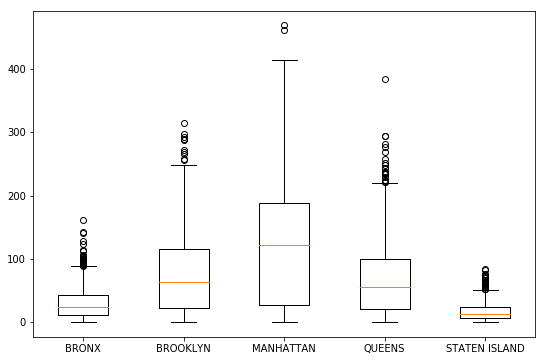

In [73]:
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(boro_data)

# Add tickers
ax.set_xticklabels(boros)

# Save the figure #fig.savefig('fig1.png', bbox_inches='tight')
plt.show()

In [21]:
cuisine_count = data_df.groupby(['cuisine_description']).count()
#cuisine_count = pd.DataFrame(violation_count)
#cuisine_count = violation_count.reset_index()
cuisine_count

,action,boro,building,camis,critical_flag,dba,grade,grade_date,inspection_date,inspection_type,phone,record_date,score,street,violation_code,violation_description,zipcode
cuisine_description,,,,,,,,,,,,,,,,,
Afghan,168,168,168,168,168,168,92,92,168,168,168,168,160,168,166,166,168
African,1593,1594,1594,1594,1594,1594,665,656,1594,1593,1594,1594,1522,1594,1572,1548,1525
American,82304,82327,82265,82327,82327,82327,43207,42725,82327,82304,82327,82327,78407,82327,81209,80607,80571
Armenian,279,279,279,279,279,279,164,164,279,279,279,279,270,279,273,271,279
Asian,6030,6039,6039,6039,6039,6039,2823,2785,6039,6030,6039,6039,5778,6039,5982,5935,5978
Australian,329,329,329,329,329,329,151,151,329,329,329,329,307,329,326,325,329
Bagels/Pretzels,2722,2724,2724,2724,2724,2724,1460,1444,2724,2722,2724,2724,2625,2724,2693,2678,2652
Bakery,11594,11598,11598,11598,11598,11598,5937,5890,11598,11594,11598,11598,11148,11598,11461,11381,11499
Bangladeshi,1066,1066,1066,1066,1066,1066,432,423,1066,1066,1066,1066,1021,1066,1049,1044,1024


In [24]:
data_df['cuisine_description'].unique()

array(['Bakery', 'Hamburgers', 'Irish', 'American', 'Delicatessen',
       'Ice Cream, Gelato, Yogurt, Ices', 'Hotdogs', 'Jewish/Kosher',
       'Chinese', 'Sandwiches/Salads/Mixed Buffet', 'Caribbean', 'Donuts',
       'Bagels/Pretzels', 'Continental', 'Pizza', 'Soul Food',
       'Pizza/Italian', 'Steak', 'Italian', 'Polish',
       'Latin (Cuban, Dominican, Puerto Rican, South & Central American)',
       'German', 'French', 'Mexican', 'Spanish', 'CafÃ©/Coffee/Tea',
       'Seafood', 'Tex-Mex',
       'Bottled beverages, including water, sodas, juices, etc.',
       'Pancakes/Waffles', 'Japanese', 'Greek', 'Thai', 'Indian',
       'Mediterranean', 'Russian', 'Californian', 'Eastern European',
       'Chicken', 'Ethiopian', 'Barbecue', 'Middle Eastern', 'Korean',
       'Egyptian', 'English', 'Other', 'Chinese/Cuban', 'Asian',
       'Portuguese', 'Indonesian', 'Armenian', 'Turkish', 'Moroccan',
       'Hawaiian', 'Vegetarian', 'Filipino',
       'Juice, Smoothies, Fruit Salads', 'Sa

In [27]:
data_df['inspection_type'].unique()

array(['Cycle Inspection / Initial Inspection',
       'Cycle Inspection / Re-inspection',
       'Smoke-Free Air Act / Re-inspection',
       'Administrative Miscellaneous / Initial Inspection',
       'Cycle Inspection / Compliance Inspection',
       'Trans Fat / Initial Inspection',
       'Cycle Inspection / Reopening Inspection',
       'Smoke-Free Air Act / Initial Inspection',
       'Calorie Posting / Initial Inspection',
       'Trans Fat / Re-inspection',
       'Administrative Miscellaneous / Re-inspection',
       'Inter-Agency Task Force / Initial Inspection',
       'Trans Fat / Compliance Inspection',
       'Administrative Miscellaneous / Compliance Inspection',
       'Administrative Miscellaneous / Second Compliance Inspection',
       'Administrative Miscellaneous / Reopening Inspection',
       'Trans Fat / Second Compliance Inspection',
       'Calorie Posting / Re-inspection',
       'Smoke-Free Air Act / Compliance Inspection',
       'Calorie Posting / Complian

In [38]:
data_df['violation_description'].unique()

array(['Pesticide use not in accordance with label or applicable laws. Prohibited chemical used/stored. Open bait station used.',
       'Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact surface or equipment improperly maintained and/or not properly sealed, raised, spaced or movable to allow accessibility for cleaning on all sides, above and underneath the unit.',
       'Food contact surface not properly washed, rinsed and sanitized after each use and following any activity when contamination may have occurred.',
       "Evidence of mice or live mice present in facility's food and/or non-food areas.",
       'Facility not vermin proof. Harborage or conditions conducive to attracting vermin to the premises and/or allowing vermin to exist.',
       'Cold food item held above 41Âº F (smoked fish and reduced oxygen packaged foods above 38 ÂºF) except during necessary preparation.',
       'Plumbing not properly installed or maintained; anti-sip